# Document Classification
### Problem statement

Black Knight operations involve processesing documents related to mortgages. They often only have access to a document we have is a scan of a fax of a print out of the document. Their system is able to read and comprehend that document, turning a PDF into structured business content that in turn their customers can act on. 

The dataset provided represents the output of the OCR stage of the data pipeline. Due to sensitive nature of the financial documents the raw text has been obscured by mapping each word to a unique value. If the word appears in multiple documents then that value will appear multiple times. The word order for the dataset comes directly from the OCR layer, so it should be roughly in order. 

### Objective:

1. Train a classification model

2. Deploy the trained model to a public cloud platform as a webservice

This notebook corresponds to the exploratory data analysis phase of the provided dataset and the benchmarking of different classification models. 
The objective is to under stand the data and identify the best classification model to be deployed as a webservice.


In [1]:
## Required packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from time import time
import collections
from typing import Tuple


#sklearn packages
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import RidgeClassifier
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import Perceptron
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.naive_bayes import BernoulliNB, ComplementNB, MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestCentroid
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn import preprocessing
from xgboost import XGBClassifier

from IPython.display import display
%matplotlib inline




/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### Data exploration:

The exploratory data analysis of the given data reveals:

1. There are in total 62152 documents (after removing empty documents) accross 14 categories. The categories indicate the different types of financial douments related to a loan/mortage. 
2.The distribution of documents across categories is plot. The largest number of documents belongs to BILL category. The APPLICATION and INTENT TO CANCEL NOTICE category has the least amount of documents.

### Preprocessing:
Generally when provided with raw text data in NLP, the data is preprocessed by removing stop words, changing the text to lower case, stemming, lemmatization.As the words are encoded in the given dataset the aforementioned steps are not executed.

The Tf-IDF for all the words is computed  and use as the feature for the classification models. The parameters values 'max-df'  and 'min-df' act as a regularizing factor for the dataset. Frequent words occuring more than 98% of the documents is filtered out as well as infrequent words (occuring less than 2% of the documents is removed from the data dictionary. Setting a max-df and min-df value will allow the classification model to generalize. Additionaly both unigram and bi-gram is considered to produce the TF-IDF matrix. Further several calssification modesl are benchmarked via 5 fold crossvalidation. 

### Benchmarking:

The second histogram shows the comparison of average accuracy and average running time on train and test sets accross 5 fold cross validation. each fold was created in a stratified manner keeping the original sample ratios for each category. A large difference between red and blue bars indicate possible overfitting of the model. After analyzing the results the LOGISTIC REGRESSION model with L2 regularization was selected to be deployed as a webservice for document classsification. It had the highest average test accuracy with good generalization. 

In [2]:
def load_data(filename):
  '''Loads the data'''
  #Read Dataset using Pandas
  data = pd.read_csv(filename)
  #Create dataframe with column names
  df = pd.DataFrame(data.values, columns=['label','doc'])
  display(df.head())
  print("Shape of data: {}".format(df.shape))

  return df

def computeMissing(df):
  '''computes the number of missing rows'''
  df.isna().sum()
  df.info()

def removeMissing(df):
  '''removes the missing rows'''
  df = df.dropna()
  df.info()

  return df

def explore(df):
  '''Explore and preprocess the data'''

  #Count NA for each column in the dataset
  computeMissing(df)
  df = removeMissing(df)

  plt.figure(figsize=(12,4))
  g = sns.barplot(df['label'].value_counts().index, df['label'].value_counts().values, alpha=0.9)
  plt.title('Class distribution', fontsize = 16)
  plt.ylabel('Frequency', fontsize=12)
  plt.xlabel('Category', fontsize=12)
  plt.xticks(rotation=90)
  plt.show()
  print(df['label'].value_counts())

  return df

def process(df):
  '''Pre-process the data'''
  
  labelEncoder = preprocessing.LabelEncoder()
  df['label'] = labelEncoder.fit_transform(df['label'])
  print(labelEncoder.inverse_transform(range(14)))
  #df['label']=labelEncoder.fit_transform(df['label'])
  display(df.head())
  
  return df

def benchmark(df):
  '''Benchmark several machine learning algorithms from sklearn'''
  
  results = []
  
  for clf, name in (
      (RidgeClassifier(tol=1e-2, solver="sag"), "Ridge Classifier"),
        (Perceptron(max_iter=50), "Perceptron"),
        (LogisticRegression(random_state=42, solver='saga',multi_class='multinomial', C=1, penalty = 'l2'), 'Logistic Regression'),
        (XGBClassifier(random_state=1,learning_rate=0.01), 'XGBoost'),
        (PassiveAggressiveClassifier(max_iter=50), "Passive-Aggressive"),
        (KNeighborsClassifier(n_neighbors=10), "kNN"),
        (RandomForestClassifier(), "Random forest")):
    
    print('=' * 80)
    print(name)
    results.append(crossValidate(clf,df))

  for penalty in ["l2", "l1"]:
      print('=' * 80)
      print("%s penalty" % penalty.upper())
      # Train Liblinear model
      results.append(crossValidate(LinearSVC(penalty=penalty, dual=False,
                                       tol=1e-3), df))

    # Train SGD model
      results.append(crossValidate(SGDClassifier(loss = 'log', alpha=.0001, max_iter=50,
                                           penalty=penalty), df))

  # Train SGD with Elastic Net penalty
  print('=' * 80)
  print("Elastic-Net penalty")
  results.append(crossValidate(SGDClassifier(loss = 'log', alpha=.0001, max_iter=50,
                                       penalty="elasticnet"), df))

 
  # Train sparse Naive Bayes classifiers
  print('=' * 80)
  print("Naive Bayes")
  results.append(crossValidate(MultinomialNB(alpha=.01), df))
  results.append(crossValidate(BernoulliNB(alpha=.01), df))
  results.append(crossValidate(ComplementNB(alpha=.1), df))

  print('=' * 80)
  
  return results;



def trainTest(clf, X_train, X_test, y_train, y_test) -> Tuple[float, float, float, float]:

  print('_' * 80)
  print("Training: ")
  print(clf)
  t0 = time()
  clf.fit(X_train, y_train)
  train_time = time() - t0
  print("train time: %0.3fs" % train_time)

  t0 = time()
  pred = clf.predict(X_test)
  test_time = time() - t0
  print("test time:  %0.3fs" % test_time)
  
  pred_train = clf.predict(X_train)
  score_train = metrics.accuracy_score(y_train, pred_train)
  score = metrics.accuracy_score(y_test, pred)
  print("accuracy train:   %0.3f" % score_train)
  print("accuracy:   %0.3f" % score)

  return score, train_time, test_time, score_train


def crossValidate(clf, df):

  fold = 0
  accuracies = []
  accuracies_train = []
  trainTimes = []
  testTimes = []
  skf = StratifiedKFold(n_splits=5, shuffle = True, random_state=42)
  for train_index, test_index in skf.split(df['doc'], df['label']):
      
      fold+=1
      #the indices for the examples in each stratified fold
      strat_train_set = df.iloc[train_index]
      strat_test_set = df.iloc[test_index]

      #Training and test examples based on stratified indices
      x_train, y_train = strat_train_set['doc'], strat_train_set['label']
      x_test, y_test = strat_test_set['doc'], strat_test_set['label']

      vectorizer = TfidfVectorizer(max_df=0.95, min_df=0.01, max_features=1037929, ngram_range=(1, 2))    
      tfidf_train = vectorizer.fit_transform(x_train)
      tfidf_test = vectorizer.transform(x_test)

      

      # Machine Learning model
      
      score =  trainTest(clf, tfidf_train, tfidf_test, y_train, y_test)
      accuracies.append(score[0])
      trainTimes.append(score[1])
      testTimes.append(score[2])
      accuracies_train.append(score[3])

  average_acc = np.mean(accuracies)
  average_acc_train = np.mean(accuracies_train)
  average_train_time = np.mean(trainTimes)
  average_test_time = np.mean(testTimes)
  clf_descr = str(clf).split('(')[0]
  print(clf_descr, 'croassvalidation average accuracy on train: ', average_acc_train)
  print(clf_descr, 'croassvalidation average accuracy: ', average_acc)
  return(clf_descr, average_acc_train, average_acc, average_train_time, average_test_time)


def compare(results):
  indices = np.arange(len(results))

  results = [[x[i] for x in results] for i in range(5)]

  clf_names, score_train, score, training_time, test_time = results
  training_time = np.array(training_time) / np.max(training_time)
  test_time = np.array(test_time) / np.max(test_time)

  plt.figure(figsize=(12, 8))
  plt.title("Benchmarking")
  plt.barh(indices, score_train, .2, label="score_train", color='red')
  plt.barh(indices + .2, score, .2, label="score", color='navy')
  plt.barh(indices + .4, training_time, .2, label="training time",
         color='c')
  plt.barh(indices + .6, test_time, .2, label="test time", color='darkorange')
  plt.yticks(())
  plt.legend(loc="lower left", mode = "expand", ncol = 4)
  plt.subplots_adjust(left=.25)
  plt.subplots_adjust(top=.95)
  plt.subplots_adjust(bottom=.05)

  for i, c in zip(indices, clf_names):
      plt.text(-.3, i, c)

  plt.show()




,label,doc
0,RETURNED CHECK,a3b334c6eefd be95012ebf2b 41d67080e078 ff1c26e...
1,BILL,586242498a88 9ccf259ca087 54709b24b45f 6bf9c0c...
2,BILL,cd50e861f48b 6ca2dd348663 d38820625542 f077614...
3,BILL,9db5536263d8 1c303d15eb65 3f89b4673455 b73e657...
4,POLICY CHANGE,10e45001c2f2 6a01047db3ab 6a8e3499dab9 97b6014...


Shape of data: (62448, 2)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62448 entries, 0 to 62447
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   62416 non-null  object
 1   doc     62154 non-null  object
dtypes: object(2)
memory usage: 975.9+ KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 62152 entries, 0 to 62446
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   62152 non-null  object
 1   doc     62152 non-null  object
dtypes: object(2)
memory usage: 1.4+ MB


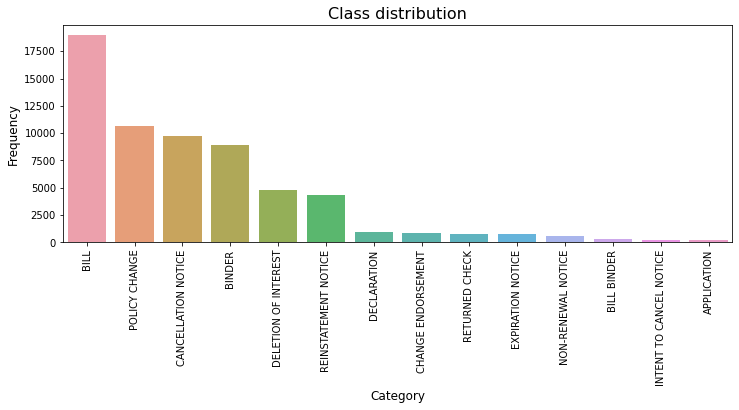

BILL                       18958
POLICY CHANGE              10616
CANCELLATION NOTICE         9727
BINDER                      8951
DELETION OF INTEREST        4825
REINSTATEMENT NOTICE        4367
DECLARATION                  966
CHANGE ENDORSEMENT           888
RETURNED CHECK               749
EXPIRATION NOTICE            734
NON-RENEWAL NOTICE           624
BILL BINDER                  289
INTENT TO CANCEL NOTICE      229
APPLICATION                  229
Name: label, dtype: int64
['APPLICATION' 'BILL' 'BILL BINDER' 'BINDER' 'CANCELLATION NOTICE'
 'CHANGE ENDORSEMENT' 'DECLARATION' 'DELETION OF INTEREST'
 'EXPIRATION NOTICE' 'INTENT TO CANCEL NOTICE' 'NON-RENEWAL NOTICE'
 'POLICY CHANGE' 'REINSTATEMENT NOTICE' 'RETURNED CHECK']


,label,doc
0,13,a3b334c6eefd be95012ebf2b 41d67080e078 ff1c26e...
1,1,586242498a88 9ccf259ca087 54709b24b45f 6bf9c0c...
2,1,cd50e861f48b 6ca2dd348663 d38820625542 f077614...
3,1,9db5536263d8 1c303d15eb65 3f89b4673455 b73e657...
4,11,10e45001c2f2 6a01047db3ab 6a8e3499dab9 97b6014...



Start of benchmarking
Ridge Classifier
________________________________________________________________________________
Training: 
RidgeClassifier(alpha=1.0, class_weight=None, copy_X=True, fit_intercept=True,
                max_iter=None, normalize=False, random_state=None, solver='sag',
                tol=0.01)


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_ridge.py:558: UserWarning: "sag" solver requires many iterations to fit an intercept with sparse inputs. Either set the solver to "auto" or "sparse_cg", or set a low "tol" and a high "max_iter" (especially if inputs are not standardized).
  '"sag" solver requires many iterations to fit '


train time: 17.815s
test time:  0.029s
accuracy train:   0.888
accuracy:   0.862
________________________________________________________________________________
Training: 
RidgeClassifier(alpha=1.0, class_weight=None, copy_X=True, fit_intercept=True,
                max_iter=None, normalize=False, random_state=None, solver='sag',
                tol=0.01)


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_ridge.py:558: UserWarning: "sag" solver requires many iterations to fit an intercept with sparse inputs. Either set the solver to "auto" or "sparse_cg", or set a low "tol" and a high "max_iter" (especially if inputs are not standardized).
  '"sag" solver requires many iterations to fit '


train time: 17.797s
test time:  0.030s
accuracy train:   0.885
accuracy:   0.863
________________________________________________________________________________
Training: 
RidgeClassifier(alpha=1.0, class_weight=None, copy_X=True, fit_intercept=True,
                max_iter=None, normalize=False, random_state=None, solver='sag',
                tol=0.01)


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_ridge.py:558: UserWarning: "sag" solver requires many iterations to fit an intercept with sparse inputs. Either set the solver to "auto" or "sparse_cg", or set a low "tol" and a high "max_iter" (especially if inputs are not standardized).
  '"sag" solver requires many iterations to fit '


train time: 19.309s
test time:  0.030s
accuracy train:   0.884
accuracy:   0.864
________________________________________________________________________________
Training: 
RidgeClassifier(alpha=1.0, class_weight=None, copy_X=True, fit_intercept=True,
                max_iter=None, normalize=False, random_state=None, solver='sag',
                tol=0.01)


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_ridge.py:558: UserWarning: "sag" solver requires many iterations to fit an intercept with sparse inputs. Either set the solver to "auto" or "sparse_cg", or set a low "tol" and a high "max_iter" (especially if inputs are not standardized).
  '"sag" solver requires many iterations to fit '


train time: 17.084s
test time:  0.030s
accuracy train:   0.885
accuracy:   0.870
________________________________________________________________________________
Training: 
RidgeClassifier(alpha=1.0, class_weight=None, copy_X=True, fit_intercept=True,
                max_iter=None, normalize=False, random_state=None, solver='sag',
                tol=0.01)


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_ridge.py:558: UserWarning: "sag" solver requires many iterations to fit an intercept with sparse inputs. Either set the solver to "auto" or "sparse_cg", or set a low "tol" and a high "max_iter" (especially if inputs are not standardized).
  '"sag" solver requires many iterations to fit '


train time: 17.381s
test time:  0.029s
accuracy train:   0.886
accuracy:   0.867
RidgeClassifier croassvalidation average accuracy on train:  0.8857518718173729
RidgeClassifier croassvalidation average accuracy:  0.8653624315149635
Perceptron
________________________________________________________________________________
Training: 
Perceptron(alpha=0.0001, class_weight=None, early_stopping=False, eta0=1.0,
           fit_intercept=True, max_iter=50, n_iter_no_change=5, n_jobs=None,
           penalty=None, random_state=0, shuffle=True, tol=0.001,
           validation_fraction=0.1, verbose=0, warm_start=False)
train time: 3.128s
test time:  0.029s
accuracy train:   0.905
accuracy:   0.830
________________________________________________________________________________
Training: 
Perceptron(alpha=0.0001, class_weight=None, early_stopping=False, eta0=1.0,
           fit_intercept=True, max_iter=50, n_iter_no_change=5, n_jobs=None,
           penalty=None, random_state=0, shuffle=True, t

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


train time: 187.413s
test time:  0.031s
accuracy train:   0.909
accuracy:   0.868
________________________________________________________________________________
Training: 
LinearSVC(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l1', random_state=None, tol=0.001,
          verbose=0)


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


train time: 193.262s
test time:  0.034s
accuracy train:   0.907
accuracy:   0.873
________________________________________________________________________________
Training: 
LinearSVC(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l1', random_state=None, tol=0.001,
          verbose=0)


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


train time: 189.707s
test time:  0.034s
accuracy train:   0.908
accuracy:   0.877
________________________________________________________________________________
Training: 
LinearSVC(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l1', random_state=None, tol=0.001,
          verbose=0)


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


train time: 188.137s
test time:  0.031s
accuracy train:   0.907
accuracy:   0.878
________________________________________________________________________________
Training: 
LinearSVC(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l1', random_state=None, tol=0.001,
          verbose=0)


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


train time: 193.453s
test time:  0.031s
accuracy train:   0.908
accuracy:   0.875
LinearSVC croassvalidation average accuracy on train:  0.9079595217294969
LinearSVC croassvalidation average accuracy:  0.8740991007287015
________________________________________________________________________________
Training: 
SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=50,
              n_iter_no_change=5, n_jobs=None, penalty='l1', power_t=0.5,
              random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)
train time: 8.908s
test time:  0.036s
accuracy train:   0.842
accuracy:   0.833
________________________________________________________________________________
Training: 
SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=Fals

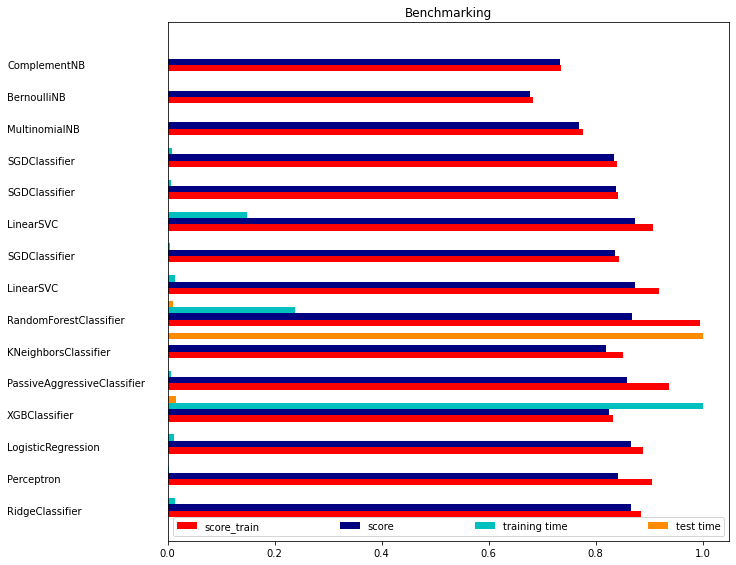


End of benchmarking


In [3]:
def main():
  df = load_data('/content/drive/My Drive/BK/shuffled-full-set-hashed-new.csv')
  df = explore(df)
  df = process(df)
  print('\nStart of benchmarking')
  result = benchmark(df)
  compare(result)
  print('\nEnd of benchmarking')

main()
